In [1]:
import numpy as np
from qiskit import execute, QuantumCircuit
from qiskit.test.mock import FakeParis
from qiskit.providers.aer import QasmSimulator, noise

from qiskit.ignis.mitigation import (
    expval_meas_mitigator_circuits,
    ExpvalMeasMitigatorFitter,
    expectation_value)

# Calibration of Mitigators

## Sim noise model

In [2]:
sim = QasmSimulator()

# Example max qubit number
num_qubits = 4

# Create readout errors
readout_errors = []
for i in range(num_qubits):
    p_error1 = (i + 1) * 0.02
    p_error0 = 2 * p_error1
    ro_error = noise.ReadoutError([[1 - p_error0, p_error0], [p_error1, 1 - p_error1]])
    readout_errors.append(ro_error)

# Readout Error only
nm = noise.NoiseModel()
for i in range(num_qubits):
    nm.add_readout_error(readout_errors[i], [i])
seed_simulator = 100

## Complete A-matrix method

In [3]:
circuits1, metadata1 = expval_meas_mitigator_circuits(num_qubits, method='complete')

job_cal1 = execute(circuits1, sim,
                   seed_simulator=seed_simulator,
                   shots=8192,
                   noise_model=nm,
                   backend_options={'method': 'density_matrix'})
result_cal1 = job_cal1.result()
complete_mitigator = ExpvalMeasMitigatorFitter(result_cal1, metadata1).fit(method='complete')

### Properties of the calibrated mitigator
We can now look at properties of the calibrated mitigator

#### Mitigation Overhead

In [4]:
delta = 0.05
print('Mitigation Overhead:', complete_mitigator.mitigation_overhead())
print('Required Shots (delta = {}): {}'.format(delta, complete_mitigator.required_shots(delta)))

Mitigation Overhead: 6
Required Shots (delta = 0.05): 8769


#### Assignment Fidelities

We can compute the single qubit avergage assignment fidelities from the mitigator

In [5]:
print('Assignment Fidelities')
for i in range(num_qubits):
    print('Qubit {}, F_m = {:.2}'.format(i, complete_mitigator.assignment_fidelity([i])))

Assignment Fidelities
Qubit 0, F_m = 0.97
Qubit 1, F_m = 0.94
Qubit 2, F_m = 0.91
Qubit 3, F_m = 0.88


### Matrix Plots

We can also plot the full Assigment and mitigation matrices A, and inverse(A)


 Assignment Matrix

Full Mitigation Matrix


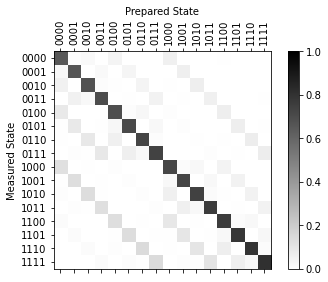

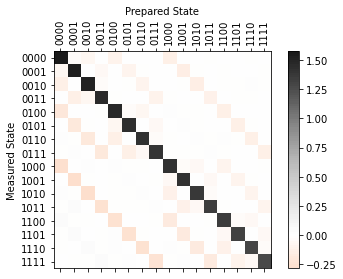

In [6]:
print('\n Assignment Matrix')
ax1 = complete_mitigator.plot_assignment_matrix()

print('\nFull Mitigation Matrix')
ax2 = complete_mitigator.plot_mitigation_matrix()

## Single-qubit Tensored A-matrix method

In [7]:
circuits2, metadata2 = expval_meas_mitigator_circuits(num_qubits, method='tensored')

job_cal2 = execute(circuits2, sim,
                   seed_simulator=seed_simulator,
                   shots=8192,
                   noise_model=nm,
                   backend_options={'method': 'density_matrix'})
result_cal2 = job_cal2.result()
tensored_mitigator = ExpvalMeasMitigatorFitter(result_cal2, metadata2).fit(method='tensored')

### Properties of the calibrated mitigator
We can now look at properties of the calibrated mitigator

#### Mitigation Overhead

In [8]:
delta = 0.05
print('Mitigation Overhead:', tensored_mitigator.mitigation_overhead())
print('Required Shots (delta = {}): {}'.format(delta, tensored_mitigator.required_shots(delta)))

Mitigation Overhead: 6
Required Shots (delta = 0.05): 8743


#### Assignment Fidelities

We can compute the single qubit avergage assignment fidelities from the mitigator

In [9]:
print('Assignment Fidelities')
for i in range(num_qubits):
    print('Qubit {}, F_m = {:.2}'.format(i, tensored_mitigator.assignment_fidelity([i])))

Assignment Fidelities
Qubit 0, F_m = 0.97
Qubit 1, F_m = 0.94
Qubit 2, F_m = 0.91
Qubit 3, F_m = 0.88


### Matrix Plots

We can also plot the full Assigment and mitigation matrices A, and inverse(A)


 Assignment Matrix

Full Mitigation Matrix


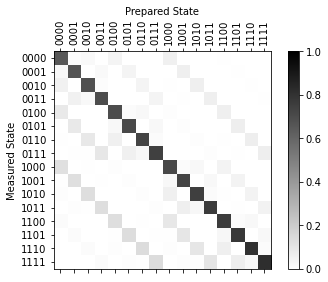

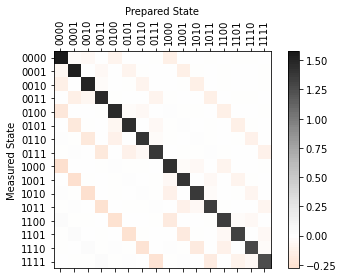

In [10]:
print('\n Assignment Matrix')
ax1 = tensored_mitigator.plot_assignment_matrix()

print('\nFull Mitigation Matrix')
ax2 = tensored_mitigator.plot_mitigation_matrix()

## Continuous-Time Markov-Process Method

In [11]:
circuits3, metadata3 = expval_meas_mitigator_circuits(num_qubits, method='CTMP')

job_cal3 = execute(circuits3, sim,
                   seed_simulator=seed_simulator,
                   shots=8192,
                   noise_model=nm,
                   backend_options={'method': 'density_matrix'})
result_cal3 = job_cal3.result()
ctmp_mitigator = ExpvalMeasMitigatorFitter(result_cal3, metadata3).fit(method='CTMP')

In [12]:
ctmp_mitigator.generator_matrix()

<16x16 sparse matrix of type '<class 'numpy.float64'>'
	with 116 stored elements in COOrdinate format>

### Properties of the calibrated mitigator
We can now look at properties of the calibrated mitigator

#### Mitigation Overhead

In [13]:
delta = 0.05
print('Mitigation Overhead:', ctmp_mitigator.mitigation_overhead())
print('Required Shots (delta = {}): {}'.format(delta, ctmp_mitigator.required_shots(delta)))

Mitigation Overhead: 7
Required Shots (delta = 0.05): 9697


#### Assignment Fidelities

We can compute the single qubit avergage assignment fidelities from the mitigator

In [14]:
print('Assignment Fidelities')
for i in range(num_qubits):
   print('Qubit {}, F_m = {:.2}'.format(i, ctmp_mitigator.assignment_fidelity([i])))

Assignment Fidelities
Qubit 0, F_m = 0.97
Qubit 1, F_m = 0.94
Qubit 2, F_m = 0.91
Qubit 3, F_m = 0.88


### Matrix Plots

We can also plot the full Assigment and mitigation matrices A, and inverse(A)

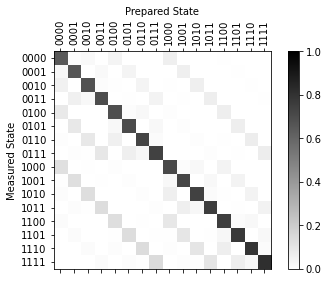

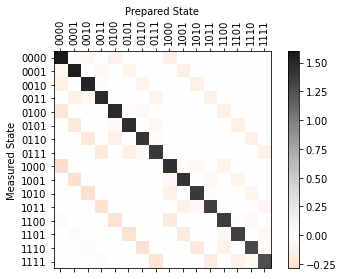

In [15]:
ax1 = ctmp_mitigator.plot_assignment_matrix()
ax2 = ctmp_mitigator.plot_mitigation_matrix()

# Error Mitigation Examples

### Expval (all-qubits)

In [16]:
# Test Circuit Measure <XXXX> stabilizer
qc = QuantumCircuit(4, 4)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.h(range(4))
qc.measure(range(4), range(4))

# Simulation
shots = 8192
result_target = execute(qc, sim, shots=shots).result()
result_noise = execute(qc, sim, shots=shots, noise_model=nm).result()
counts_target = result_target.get_counts(0)
counts_noise = result_noise.get_counts(0)

# Expvals
expvals = [
    ('Target', expectation_value(counts_target)),
    ('Unmitigated', expectation_value(counts_noise)),
    ('Mitigated (Complete)', expectation_value(counts_noise, meas_mitigator=complete_mitigator)),
    ('Mitigated (Tensored)', expectation_value(counts_noise, meas_mitigator=tensored_mitigator)),
    ('Mitigated (CTMP)', expectation_value(counts_noise, meas_mitigator=ctmp_mitigator)),
]
print('\nExpectation Values')
for label, expval in expvals:
    print('- {}: {:.3f} \u00B1 {:.3f}'.format(label, expval[0], expval[1]))


Expectation Values
- Target: 1.000 ± 0.000
- Unmitigated: 0.517 ± 0.009
- Mitigated (Complete): 1.004 ± 0.018
- Mitigated (Tensored): 0.998 ± 0.018
- Mitigated (CTMP): 0.992 ± 0.027


### Expval (all-qubits, permuted)

NOTE: This is not yet implemented for CTMP method

In [17]:
for meas_qubits in [[0, 1, 2, 3], [0, 1, 3, 2], [1, 3, 0, 2], [3, 0, 1, 2], [2, 0, 3, 1], [3, 2, 1, 0]]:

    # Test Circuit Measure <XXXX> stabilizer
    qc = QuantumCircuit(4, 4)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.h(range(4))
    qc.measure(meas_qubits, range(4))

    # Simulation
    shots = 8192

    result_target = execute(qc, sim, shots=shots, seed_simulator=seed_simulator).result()
    result_noise = execute(qc, sim, shots=shots,seed_simulator=seed_simulator,
                           noise_model=nm).result()
    counts_target = result_target.get_counts(0)
    counts_noise = result_noise.get_counts(0)

    # Expvals
    expvals = [
        ('Target', expectation_value(counts_target)),
        ('Unmitigated', expectation_value(counts_noise)),
        ('Mitigated (Complete)', expectation_value(counts_noise, 
                                                   meas_mitigator_qubits=meas_qubits,
                                                   meas_mitigator=complete_mitigator)),
        ('Mitigated (Tensored)', expectation_value(counts_noise,
                                                   meas_mitigator_qubits=meas_qubits,
                                                   meas_mitigator=tensored_mitigator)),
        ('Mitigated (CTMP)', expectation_value(counts_noise,
                                               meas_mitigator_qubits=meas_qubits,
                                               meas_mitigator=ctmp_mitigator)),
    ]
    print('\nExpectation Values (meas qubits {})'.format(meas_qubits))
    for label, expval in expvals:
        print('- {}: {:.3f} \u00B1 {:.3f}'.format(label, expval[0], expval[1]))


Expectation Values (meas qubits [0, 1, 2, 3])
- Target: 1.000 ± 0.000
- Unmitigated: 0.531 ± 0.009
- Mitigated (Complete): 1.028 ± 0.018
- Mitigated (Tensored): 1.020 ± 0.018
- Mitigated (CTMP): 1.038 ± 0.027

Expectation Values (meas qubits [0, 1, 3, 2])
- Target: 1.000 ± 0.000
- Unmitigated: 0.519 ± 0.009
- Mitigated (Complete): 1.005 ± 0.018
- Mitigated (Tensored): 0.998 ± 0.018
- Mitigated (CTMP): 0.988 ± 0.027

Expectation Values (meas qubits [1, 3, 0, 2])
- Target: 1.000 ± 0.000
- Unmitigated: 0.514 ± 0.009
- Mitigated (Complete): 0.996 ± 0.018
- Mitigated (Tensored): 0.989 ± 0.018
- Mitigated (CTMP): 1.024 ± 0.027

Expectation Values (meas qubits [3, 0, 1, 2])
- Target: 1.000 ± 0.000
- Unmitigated: 0.521 ± 0.009
- Mitigated (Complete): 1.012 ± 0.018
- Mitigated (Tensored): 1.005 ± 0.018
- Mitigated (CTMP): 0.999 ± 0.027

Expectation Values (meas qubits [2, 0, 3, 1])
- Target: 1.000 ± 0.000
- Unmitigated: 0.500 ± 0.010
- Mitigated (Complete): 0.967 ± 0.018
- Mitigated (Tensored)

### Expval Partial Qubits

NOTE: This is not yet implemented for CTMP method

In [18]:
for qubits in [[0, 1], [0, 2], [0, 3], [3, 1], [2, 1], [3, 2], [2, 3]]:
    
    # Test Circuit
    qc = QuantumCircuit(4, 2)
    qc.h(qubits[0])
    qc.cx(qubits[0], qubits[1])
    qc.measure(qubits, [0, 1])

    # Simulation
    shots = 8192
    seed = 1101
    result_target = execute(qc, sim, shots=shots, seed_simulator=seed_simulator).result()
    result_noise = execute(qc, sim, shots=shots,seed_simulator=seed_simulator,
                           noise_model=nm).result()
    counts_target = result_target.get_counts(0)
    counts_noise = result_noise.get_counts(0)

    # Expvals
    expvals = [
        ('Target', expectation_value(counts_target)),
        ('Unmitigated', expectation_value(counts_noise)),
        ('Mitigated (Complete)', expectation_value(counts_noise, 
                                                   meas_mitigator_qubits=qubits,
                                                   meas_mitigator=complete_mitigator)),
        ('Mitigated (Tensored)', expectation_value(counts_noise,
                                                   meas_mitigator_qubits=qubits,
                                                   meas_mitigator=tensored_mitigator)),
        ('Mitigated (CTMP)', expectation_value(counts_noise,
                                               meas_mitigator_qubits=qubits,
                                               meas_mitigator=ctmp_mitigator)),
    ]
    print('\nExpectation Values (meas qubits {})'.format(meas_qubits))
    for label, expval in expvals:
        print('- {}: {:.3f} \u00B1 {:.3f}'.format(label, expval[0], expval[1]))


Expectation Values (meas qubits [3, 2, 1, 0])
- Target: 1.000 ± 0.000
- Unmitigated: 0.827 ± 0.006
- Mitigated (Complete): 1.000 ± 0.008
- Mitigated (Tensored): 0.997 ± 0.008
- Mitigated (CTMP): 1.004 ± 0.014

Expectation Values (meas qubits [3, 2, 1, 0])
- Target: 1.000 ± 0.000
- Unmitigated: 0.774 ± 0.007
- Mitigated (Complete): 0.996 ± 0.009
- Mitigated (Tensored): 1.001 ± 0.009
- Mitigated (CTMP): 1.016 ± 0.016

Expectation Values (meas qubits [3, 2, 1, 0])
- Target: 1.000 ± 0.000
- Unmitigated: 0.717 ± 0.008
- Mitigated (Complete): 1.003 ± 0.011
- Mitigated (Tensored): 1.000 ± 0.011
- Mitigated (CTMP): 1.013 ± 0.017

Expectation Values (meas qubits [3, 2, 1, 0])
- Target: 1.000 ± 0.000
- Unmitigated: 0.670 ± 0.008
- Mitigated (Complete): 0.994 ± 0.012
- Mitigated (Tensored): 0.988 ± 0.012
- Mitigated (CTMP): 1.016 ± 0.019

Expectation Values (meas qubits [3, 2, 1, 0])
- Target: 1.000 ± 0.000
- Unmitigated: 0.721 ± 0.008
- Mitigated (Complete): 0.993 ± 0.011
- Mitigated (Tensored)